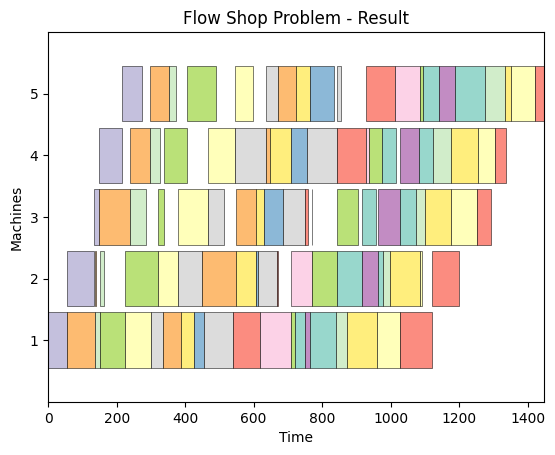

In [1]:
import flow_shop as fs

#Read and display data 
df = fs.DatasetReader('database/tai20_5.txt').read_data(0)

c_t, c_a = fs.calculate_completion_time(df, return_comp_arr=True)
fs.display_graph(df, c_t, c_a)


In [10]:
# All possible neighborhood transformation
TRANSFORMS = {
    0: fs.swap,
    1: fs.reverse_subsequence,
    2: fs.insert_before,
    3: fs.insert_after
}

TRANSFORMS_KEYS = list(TRANSFORMS.keys())

![Tabu Search Flow Diagram](doc/img/TabuSearch.png "Tabu Search")

In [106]:
# Trial implementation Tabu Search 
import random

def generate_n_different_value(n_values: int, min_value: int, max_value: int):
    if (max_value - min_value + 1) < n_values:
        raise ValueError("Incorrect range value")

    values = list()
    while len(values) < n_values:
        value = random.randint(min_value, max_value)
        if value not in values:
            values.append(value)
    
    return values


def generate_neighbor_options(n_jobs):    
    action = random.choice(TRANSFORMS_KEYS) # Roll action on set
    indexes = generate_n_different_value(2, 0, n_jobs-1) # Roll 2 indexes
    if action in [0,1]: #If action is fs.swap or fs.reverse_subsequence then sort indexes
        indexes.sort()

    return {'action': action, 'indexes': indexes}


class TabuList:
    def __init__(self, length: int) -> None:
        self.length = length
        self.tabu_list = [{'action': 0, 'indexes': [0,0]} for i in range(length)]
        self.current_index = 0 

    def __contains__(self, operation):
        return operation in self.tabu_list

    def push(self, operation: dict):
        self.tabu_list[self.current_index] = operation
        self.current_index = (self.current_index+1)%self.length

In [130]:
x = df.processing_time.copy() #Starting solution
x_best = x.copy() # Best solution
t_best = fs.calculate_completion_time(x_best, df.n_jobs, df.m_machines) # Time of best solution

tabu_list = TabuList(3)
neighbor_size = 5 # Should be bigger than tabu list

aspiration_criterial = 0 # Better than best solution mor than aspiration_criterial

best = list()

for _ in range(1000):
    #Generate neighbor solutions
    neighbor_actions = [generate_neighbor_options(df.n_jobs) for _ in range(neighbor_size)]
    neighbor_time = [1e6 for _ in range(neighbor_size)]
    for i, action in enumerate(neighbor_actions):
        xp = TRANSFORMS[action['action']](x, action['indexes'][0],action['indexes'][1])
        neighbor_time[i] = fs.calculate_completion_time(xp, df.n_jobs, df.m_machines)  # type: ignore

    # Found best neighbor solutions
    founded_best_neighbor = False
    while len(neighbor_time) > 0 and not founded_best_neighbor:
        best_neighbor_idx = neighbor_time.index(max(neighbor_time))
        if neighbor_actions[best_neighbor_idx] in tabu_list:
            if (neighbor_time[best_neighbor_idx]+aspiration_criterial) < t_best:  # type: ignore
                founded_best_neighbor = True
            else:
                neighbor_time.pop(best_neighbor_idx)
        else:
            founded_best_neighbor = True
    
    if founded_best_neighbor == False:
        continue

    # If better than best solution
    action = neighbor_actions[best_neighbor_idx]
    if neighbor_time[best_neighbor_idx] < t_best:  # type: ignore
        t_best = neighbor_time[best_neighbor_idx]
        x_best = TRANSFORMS[action['action']](x, action['indexes'][0],action['indexes'][1])
    
    x = TRANSFORMS[action['action']](x, action['indexes'][0],action['indexes'][1])
    
    tabu_list.push(action)
      

print(t_best)    

1448.0


0   20
0   21
0   22
1   20
1   21
1   22
2   20
2   21
2   22
3   20
3   21
3   22
4   20
4   21
4   22
5   20
5   21
5   22
6   20
6   21
6   22
7   20
7   21
7   22
8   20
8   21
8   22
9   20
9   21
9   22
